## Uncertainty in Explanations via Input Perturbation

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from skimage.color import gray2rgb
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.append('./xplique/')
from xplique.attributions import Lime, Saliency

2025-01-08 17:46:42.662208: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-08 17:46:43.109588: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 47121 MB memory:  -> device: 0, name: Quadro RTX 8000, pci bus id: 0000:65:00.0, compute capability: 7.5


In [3]:
# Load and Prepare MNIST Dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize to [0, 1]
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

In [4]:
# Build and train a simple CNN
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(x_train, y_train, epochs=2, batch_size=64, validation_split=0.25)

Epoch 1/2


2025-01-08 17:46:45.343361: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8401
2025-01-08 17:46:45.858492: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 17:46:45.859511: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 17:46:45.859523: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2025-01-08 17:46:45.860465: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-01-08 17:46:45.860533: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


704/704 [==============================] - 6s 6ms/step - loss: 0.1991 - accuracy: 0.9418 - val_loss: 0.0829 - val_accuracy: 0.9753
Epoch 2/2
704/704 [==============================] - 4s 6ms/step - loss: 0.0629 - accuracy: 0.9805 - val_loss: 0.0600 - val_accuracy: 0.9819


In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 64)                1

In [6]:
# Explain sample prediction
sample_index = 0
sample_image, sample_label = x_test[sample_index], y_test[sample_index]
#sample_image = gray2rgb(sample_image.squeeze())  # LIME expects RGB images
sample_image = np.expand_dims(sample_image, axis=0)
sample_label = np.expand_dims(sample_label, axis=0)

model.layers[-1].activation = tf.keras.activations.linear
explainer = Saliency(model)
#explainer = Lime(model)
explanation = explainer.explain(sample_image, sample_label)

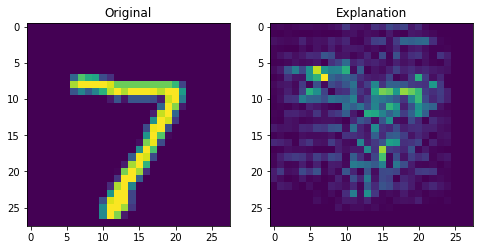

In [7]:
# Display explanation
plt.figure(figsize=(8,10))
plt.subplot(121)
plt.imshow(sample_image.squeeze()) # shape (1, 28, 28, 1)
plt.title("Original")
plt.subplot(122)
plt.imshow(explanation[0]) # shape (1, 28, 28)
plt.title("Explanation")
#plt.colorbar()
plt.show()

### Mathematical considerations

Let the explainer be

$$e_{\theta, f}: \mathbb{R}^{n \cdot k \cdot l \cdot r} \rightarrow \mathbb{R}^m$$

with the explanation in the form $e_{\theta, f}(x, \hat{y})$.

Dimensions:

+ $n$: input $x = (x_1, ..., x_n)$
+ $k$: prediction $f(x) = \hat{y} = (\hat{y}_1, ..., \hat{y}_k)$
+ $l$: parameters of the XAI method $\theta = (\theta_1, ..., \theta_l)$ (in case it has any)
+ $r$: model parameters $\omega = (\omega_1, ..., \omega_r)$
+ $m$: explanation $e = (e_1, ..., e_m)$

The (full) Jacobian of the explainer $e$ w.r.t. all the inputs has the form:

$$\mathbb{J}_e = [\frac{\partial e}{\partial x} \frac{\partial e}{\partial \hat{y}} \frac{\partial e}{\partial \theta} \frac{\partial e}{\partial \omega}]$$

If looking only at the sensitivity of the explanation w.r.t. to the input $x$, then the derivative is:

$$\frac{\partial e}{\partial x} = \begin{bmatrix}
\frac{de_1}{dx_1} & ... & \frac{de_1}{dx_n}\\
... & ... & ...\\
\frac{de_m}{dx_1} & ... & \frac{de_m}{dx_n}
\end{bmatrix}$$

$$Var(e(\widetilde{x},\hat{y})) \approx \frac{\partial e}{\partial x}(x,\hat{y}) \cdot \Sigma_{\Delta x} \cdot \frac{\partial e}{\partial x}(x,\hat{y})^T$$

If the perturbance in every pixel is normally distributed with the same variance, then the covariance becomes:

$$\Delta x \sim \mathcal{N}(0, \sigma^2 I), \Sigma_{\Delta x} = \sigma^2 I$$

Hence, the covariance matrix of the explanation becomes:

$$Var(e(\widetilde{x},\hat{y})) \approx \sigma^2 \frac{\partial e}{\partial x}(x,\hat{y}) \cdot \frac{\partial e}{\partial x}(x,\hat{y})^T$$

In [8]:
# Compute derivative of explanation w.r.t input via FDM
h = 1e-4
sample_image = sample_image.squeeze()
n = np.product(np.shape(sample_image))
m = np.product(np.shape(explanation))
h, w = sample_image.shape[0], sample_image.shape[1]
derivative_e_x = np.zeros((m, n))

# For every pixel perturbation, we get a new column in the Jacobian
for i in range(h):
    for j in range(w):
        # Perturb pixel (i, j)
        perturbed_image = np.copy(sample_image)
        perturbed_image[i, j] += h
        perturbed_image = np.clip(perturbed_image, 0, 1)  # Keep within valid range

        # Compute explanation for perturbed image
        perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)

        # Compute finite difference gradient
        derivative_2d = (perturbed_explanation[0] - explanation[0]) / h

        # Fill out the corresponding column in the jacobian
        flat_ind = i * w + j
        derivative_e_x[:, flat_ind] = derivative_2d.numpy().reshape(m, )

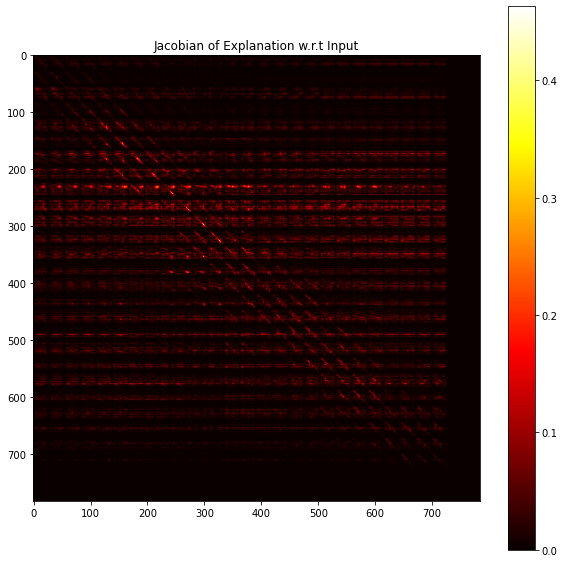

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(derivative_e_x), cmap='hot')
plt.title("Jacobian of Explanation w.r.t Input")
plt.colorbar()
plt.show()

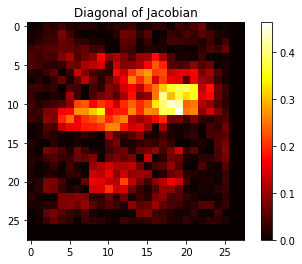

In [10]:
plt.imshow(np.abs(np.diag(derivative_e_x).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Jacobian")
plt.colorbar()
plt.show()

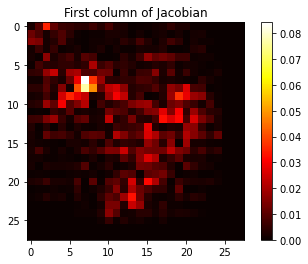

In [11]:
plt.imshow(np.abs(derivative_e_x[:,0].reshape(h,w)), cmap='hot')
plt.title("First column of Jacobian")
plt.colorbar()
plt.show()

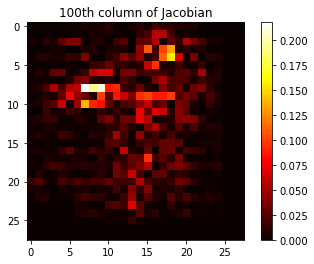

In [32]:
plt.imshow(np.abs(derivative_e_x[:,100].reshape(h,w)), cmap='hot')
plt.title("100th column of Jacobian")
plt.colorbar()
plt.show()

In [38]:
# Approximate covariance of explanation
perturbation_std = 0.1
sigma_squared = perturbation_std ** 2
variance_explanation = sigma_squared * derivative_e_x @ derivative_e_x.T

# Total variance is the trace of the cov. matrix
print("Total Variance of Explanation (Analytical):", np.trace(variance_explanation))

Total Variance of Explanation (Analytical): 3.045403143006769


In [39]:
# Normalized total variance is the trace of the cov. matrix divided by the L2-norm of the unperturbed explanation
print("Normalized Variance of Explanation:", np.trace(variance_explanation) / np.linalg.norm(explanation))

Normalized Variance of Explanation: 0.11407734858039101


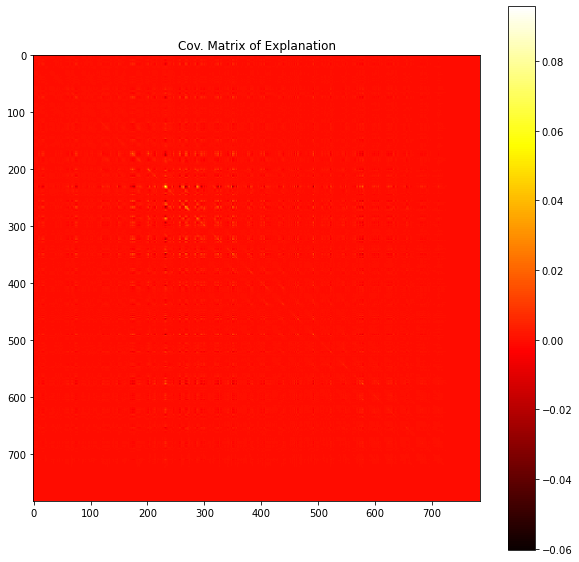

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(variance_explanation, cmap='hot')
plt.title("Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

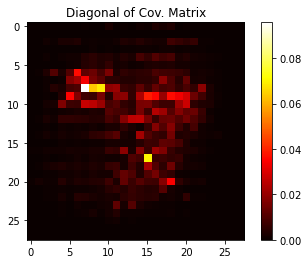

In [48]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(variance_explanation).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Cov. Matrix")
plt.colorbar()
plt.show()

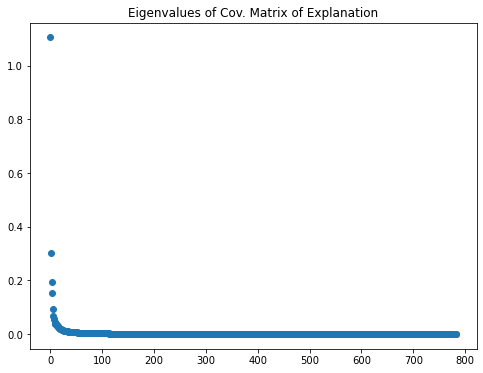

In [28]:
# Explained variance ratio
evals, evecs = np.linalg.eig(variance_explanation)

plt.figure(figsize=(8,6))
plt.plot(evals, 'o')
plt.title('Eigenvalues of Cov. Matrix of Explanation');

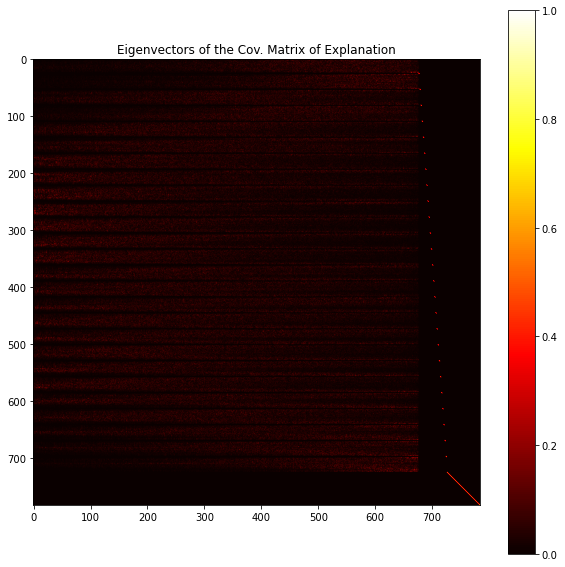

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(np.abs(evecs), cmap='hot')
plt.title("Eigenvectors of the Cov. Matrix of Explanation")
plt.colorbar()
plt.show()

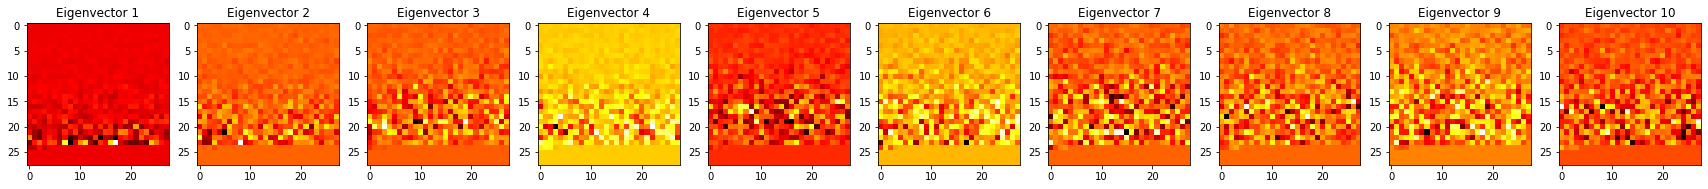

In [49]:
# First k eigenvectors (sorted from highest to lowest eigenvalue)
min_val, max_val = np.min(evecs[:10]), np.max(evecs[:10])
plt.figure(figsize=(30,8))
for i in range(10):
    evec_norm = (evecs[i] - min_val) / (max_val - min_val)
    plt.subplot(1, 10, i+1)
    plt.imshow(evec_norm.reshape(h,w), cmap='hot')
    plt.title("Eigenvector " + str(i+1))
plt.show()

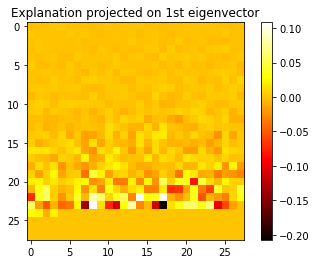

In [53]:
# Project explanation onto the dominant eigenvector
comp_on_projection = np.dot(explanation.numpy().flatten(), evecs[0])
projected_explanation = comp_on_projection * evecs[0]

plt.imshow(projected_explanation.reshape(h,w), cmap='hot')
plt.title("Explanation projected on 1st eigenvector")
plt.colorbar()
plt.show()

### Compute variance empirically

In [57]:
num_perturbations = 50
perturbation_std = 0.1  # same as above for analytical formula
sigma_squared = perturbation_std ** 2

perturbed_explanations = []
for _ in range(num_perturbations):
    # Add Gaussian noise to the input image
    perturbed_image = sample_image + np.random.normal(0, perturbation_std, sample_image.shape)
    perturbed_image = np.clip(perturbed_image, 0, 1)  # Ensure valid pixel range

    # Generate explanation for perturbed input
    perturbed_explanation = explainer.explain(np.expand_dims(perturbed_image, axis=[0,3]), sample_label)
    perturbed_explanations.append(perturbed_explanation.numpy().flatten())

# Stack explanations and compute covariance matrix
explanation_matrix = np.stack(perturbed_explanations, axis=0)
empirical_covariance = np.cov(explanation_matrix, rowvar=False)

# Compute total variance (trace of the covariance matrix)
empirical_total_variance = np.trace(empirical_covariance)

print("Empirical Total Variance of Explanation:", empirical_total_variance)

Empirical Total Variance of Explanation: 303.6296168098943


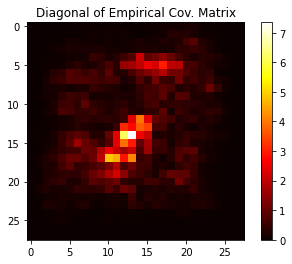

In [59]:
# Per Pixel Variance
plt.imshow(np.abs(np.diag(empirical_covariance).reshape(h,w)), cmap='hot')
plt.title("Diagonal of Empirical Cov. Matrix")
plt.colorbar()
plt.show()